# Objective : 
This notebook goes through in detail the building and evaluation of the prediction models for the Property Prices in Singapore.


# Executive Summary 

1. The best performing model is the Light GBM model with rmse of 1592876.1949810206.
2. The important variables that contributed towards the above prediction accuracy are:
    - size_sqft
    - years_left
    - distance based features - 
        * dist_from_nearest_sschool
        * dist_from_nearest_mall
        * dist_from_nearest_mrt				

In [200]:
#Import libraries
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from datetime import datetime
import re
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.figure_factory as ff
import pickle
import sklearn.metrics as metrics

from sklearn.linear_model import Ridge

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected = True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly import tools

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

import warnings
warnings.filterwarnings(action='ignore')

import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback
from verstack import LGBMTuner
import geopy.distance

import eda_func
#to make sure kernel restart is not needed after making changes in .py
import importlib
importlib.reload(eda_func)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from datetime import datetime


<module 'eda_func' from 'F:\\Projects\\learning\\CS5228\\Regression\\eda_func.py'>

In [201]:
#Read data 
train_df = pd.read_csv("train_df_for_model.csv")
test_df = pd.read_csv("test_df_for_model.csv")
subzone_df = pd.read_csv("auxiliary-data/sg-subzones.csv")
print(train_df.shape,test_df.shape)

(20145, 18) (6966, 17)


In [202]:
#display all columns 
pd.set_option("display.max_columns",None)
train_df.head(2)

,property_type,num_beds,size_sqft,floor_level,furnishing,lat,lng,subzone,planning_area,price,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt
0,hdb,3,1115,unknown,unspecified,1.414399,103.837196,yishun south,yishun,514500.0,65,17.97,14.51,0.62,0.18,0.27,3.34,0.57
1,hdb,4,1575,unknown,unspecified,1.372597,103.875625,serangoon north,serangoon,995400.0,69,12.67,10.17,0.55,0.29,0.12,2.39,1.73


## Merge subzone 
Adding population and area_size using the auxiliary dataset.

In [203]:
pop_area_sub = subzone_df.groupby(['planning_area'])[['area_size','population']].mean().reset_index()
pop_area_sub['population'] =pop_area_sub['population'].astype('int')
train_df = pd.merge(train_df, pop_area_sub, how="left", on=["planning_area"])
test_df = pd.merge(test_df, pop_area_sub, how="left", on=["planning_area"])
print(train_df.shape,test_df.shape)

(20145, 20) (6966, 19)


In [204]:
# check for null values 
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


In [205]:
# save the copy of test data to create submission.csv later,
# its saved before feature engineering, so that we can run few EDA on test data copy
submit=test_df.copy() 
submit.head(3)

,property_type,num_beds,size_sqft,floor_level,furnishing,lat,lng,subzone,planning_area,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt,area_size,population
0,condo,1,463.0,unknown,unfurnished,1.344334,103.878690,upper paya lebar,serangoon,999,12.30,7.33,0.99,0.34,0.34,1.04,0.26,1.442943,16700
1,condo,3,1033.0,high,unspecified,1.380281,103.943878,pasir ris west,pasir ris,94,5.56,14.81,0.28,1.40,1.08,1.44,1.00,1.879487,18390
2,condo,1,570.0,unknown,fully,1.294668,103.850074,bras basah,museum,84,16.90,1.20,0.21,0.56,0.34,0.16,0.25,0.276500,173


In [206]:
#final dataset for feature engineering 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20145 entries, 0 to 20144
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              20145 non-null  object 
 1   num_beds                   20145 non-null  int64  
 2   size_sqft                  20145 non-null  int64  
 3   floor_level                20145 non-null  object 
 4   furnishing                 20145 non-null  object 
 5   lat                        20145 non-null  float64
 6   lng                        20145 non-null  float64
 7   subzone                    20145 non-null  object 
 8   planning_area              20145 non-null  object 
 9   price                      20145 non-null  float64
 10  years_left                 20145 non-null  int64  
 11  dist_from_changi_airport   20145 non-null  float64
 12  dist_from_cbd              20145 non-null  float64
 13  dist_from_nearest_mall     20145 non-null  flo

# Feature Engineering

## Categorical Data Encoding

Checking unique values across different categorial variable 

In [208]:
cat_cols = train_df.select_dtypes(include = ['object']).columns.to_list()
cat_cols

['property_type', 'floor_level', 'furnishing', 'subzone', 'planning_area']

In [209]:
train_df['property_type'].value_counts()

condo     11095
hdb        6326
landed     2685
others       39
Name: property_type, dtype: int64

In [210]:
train_df['floor_level'].value_counts()

unknown      16637
high          1684
low            723
mid            706
ground         182
top            116
penthouse       97
Name: floor_level, dtype: int64

In [211]:
train_df['furnishing'].value_counts()

unspecified    14619
partial         2989
unfurnished     2008
fully            529
Name: furnishing, dtype: int64

In [212]:
train_df['planning_area'].nunique()

43

In [213]:
train_df['subzone'].nunique()

244

In [214]:
train_df.drop(['subzone'], axis=1,inplace=True)
test_df.drop(['subzone'], axis=1,inplace=True)

In [215]:
cat_onehot= ['property_type','furnishing' ]
cat_label =['floor_level']
cat_target=['planning_area']

### one-hot encoding 
With only 4 distinct types, property type and furnishing are one-hot encoded.

In [216]:
# #one hot encoding 
train_df=pd.get_dummies(train_df, columns=cat_onehot)
test_df=pd.get_dummies(test_df, columns=cat_onehot)

### label encoding 
Since the Floor level has an order, we have used label encoding for it

In [217]:
le = LabelEncoder()
for i in range(len(cat_label)):
    le.fit(np.hstack((train_df[cat_label[i]],test_df[cat_label[i]])))
    train_df[cat_label[i]] = le.transform(train_df[cat_label[i]])
    test_df[cat_label[i]] = le.transform(test_df[cat_label[i]])

In [218]:
train_df.head(10)

,num_beds,size_sqft,floor_level,lat,lng,planning_area,price,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt,area_size,population,property_type_condo,property_type_hdb,property_type_landed,property_type_others,furnishing_fully,furnishing_partial,furnishing_unfurnished,furnishing_unspecified
0,3,1115,7,1.414399,103.837196,yishun,514500.0,65,17.97,14.51,0.62,0.18,0.27,3.34,0.57,2.314344,24623,0,1,0,0,0,0,0,1
1,4,1575,7,1.372597,103.875625,serangoon,995400.0,69,12.67,10.17,0.55,0.29,0.12,2.39,1.73,1.442943,16700,0,1,0,0,0,0,0,1
2,4,3070,3,1.298773,103.895798,marine parade,8485000.0,999,12.19,5.20,0.82,0.89,0.89,2.16,1.32,1.224120,9244,1,0,0,0,0,1,0,0
3,3,958,7,1.312364,103.803271,bukit timah,2626000.0,1000,21.21,6.22,0.91,1.10,1.09,1.61,0.72,2.189375,9731,1,0,0,0,0,1,0,0
4,2,732,7,1.273959,103.843635,downtown core,1764000.0,103,18.58,1.41,0.43,1.54,0.46,1.86,0.37,0.373577,246,1,0,0,0,0,0,0,1
5,2,689,7,1.339338,103.763893,bukit batok,1702000.0,1001,25.07,11.51,1.40,1.48,0.39,2.23,1.33,1.237811,17561,1,0,0,0,0,0,0,1
6,3,1076,7,1.310640,103.852149,kallang,2475900.0,103,16.03,2.95,0.41,1.28,0.25,1.42,0.40,0.911178,11254,1,0,0,0,0,0,0,1
7,5,11500,7,1.342340,103.784489,bukit timah,15645000.0,856,22.76,9.86,0.79,2.36,1.03,4.01,0.73,2.189375,9731,0,0,1,0,0,0,0,1
8,1,700,0,1.315535,103.825684,tanglin,1312500.0,991,18.70,4.52,1.07,0.75,1.10,2.03,0.50,1.888100,5452,1,0,0,0,0,0,0,1
9,2,570,7,1.310429,103.802821,bukit timah,1802500.0,1002,21.31,6.16,0.84,0.88,1.22,1.48,0.74,2.189375,9731,1,0,0,0,0,0,0,1


### Target Encoding

There are 244 subzones and 43 planning areas. Both of these categorical features possess high cardinality. One hot encoding them may result in both space consumption and the curse of dimensionality problem. In most cases, high cardinality makes it difficult for the model to identify such patterns and hence the model does not generalise well to examples outside the training set. Therefore, we could go with target encoding which involves replacing a categorical feature with the average target value of all data points belonging to the category. Target encoding, however, may cause data leakage, so we are only using it for the planning area and have removed the feature subzone.

In [219]:
import category_encoders as ce
sub=ce.TargetEncoder() 
df_train_sub=sub.fit_transform(train_df[cat_target],train_df['price'])
df_test_sub =sub.transform(test_df[cat_target])


train_df = df_train_sub.join(train_df.drop(cat_target,axis = 1))
test_df = df_test_sub.join(test_df.drop(cat_target,axis = 1))

In [220]:
print(train_df.shape,test_df.shape)

(20145, 25) (6966, 24)


In [221]:
train_df.head(10)

,planning_area,num_beds,size_sqft,floor_level,lat,lng,price,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt,area_size,population,property_type_condo,property_type_hdb,property_type_landed,property_type_others,furnishing_fully,furnishing_partial,furnishing_unfurnished,furnishing_unspecified
0,1.143610e+06,3,1115,7,1.414399,103.837196,514500.0,65,17.97,14.51,0.62,0.18,0.27,3.34,0.57,2.314344,24623,0,1,0,0,0,0,0,1
1,3.695706e+06,4,1575,7,1.372597,103.875625,995400.0,69,12.67,10.17,0.55,0.29,0.12,2.39,1.73,1.442943,16700,0,1,0,0,0,0,0,1
2,4.165337e+06,4,3070,3,1.298773,103.895798,8485000.0,999,12.19,5.20,0.82,0.89,0.89,2.16,1.32,1.224120,9244,1,0,0,0,0,1,0,0
3,5.649879e+06,3,958,7,1.312364,103.803271,2626000.0,1000,21.21,6.22,0.91,1.10,1.09,1.61,0.72,2.189375,9731,1,0,0,0,0,1,0,0
4,4.880015e+06,2,732,7,1.273959,103.843635,1764000.0,103,18.58,1.41,0.43,1.54,0.46,1.86,0.37,0.373577,246,1,0,0,0,0,0,0,1
5,1.606542e+06,2,689,7,1.339338,103.763893,1702000.0,1001,25.07,11.51,1.40,1.48,0.39,2.23,1.33,1.237811,17561,1,0,0,0,0,0,0,1
6,2.254179e+06,3,1076,7,1.310640,103.852149,2475900.0,103,16.03,2.95,0.41,1.28,0.25,1.42,0.40,0.911178,11254,1,0,0,0,0,0,0,1
7,5.649879e+06,5,11500,7,1.342340,103.784489,15645000.0,856,22.76,9.86,0.79,2.36,1.03,4.01,0.73,2.189375,9731,0,0,1,0,0,0,0,1
8,4.890885e+06,1,700,0,1.315535,103.825684,1312500.0,991,18.70,4.52,1.07,0.75,1.10,2.03,0.50,1.888100,5452,1,0,0,0,0,0,0,1
9,5.649879e+06,2,570,7,1.310429,103.802821,1802500.0,1002,21.31,6.16,0.84,0.88,1.22,1.48,0.74,2.189375,9731,1,0,0,0,0,0,0,1


## Correlation matrix 

In [222]:
data_corr = train_df.select_dtypes(include=[np.number])
#Generate correlation matrix
corrMatrix = data_corr.corr()
corrMatrix.head(20)

,planning_area,num_beds,size_sqft,floor_level,lat,lng,price,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt,area_size,population,property_type_condo,property_type_hdb,property_type_landed,property_type_others,furnishing_fully,furnishing_partial,furnishing_unfurnished,furnishing_unspecified
planning_area,1.000000,0.098684,0.327781,0.047036,-0.564323,-0.002898,0.451934,0.329545,0.048068,-0.507171,0.350441,0.610689,0.635224,0.148316,0.247596,0.030984,-0.521340,0.233750,-0.398791,0.202557,-0.000626,-0.016407,0.032006,0.015417,-0.029971
num_beds,0.098684,1.000000,0.740122,0.135199,0.099981,0.038652,0.496750,0.152047,-0.038840,0.149973,0.177564,0.123728,0.060882,0.152547,0.196912,0.037911,0.100684,-0.344248,-0.098700,0.637068,0.011760,-0.048194,-0.059809,-0.063488,0.107551
size_sqft,0.327781,0.740122,1.000000,0.131995,-0.088336,0.040920,0.723823,0.264191,-0.028397,-0.023527,0.255568,0.316844,0.239522,0.160003,0.226083,0.037725,-0.050685,-0.324593,-0.229180,0.784939,0.023673,-0.031206,-0.050067,-0.059981,0.091347
floor_level,0.047036,0.135199,0.131995,1.000000,-0.010075,-0.003123,0.095181,0.094894,0.000905,-0.015411,0.060268,0.025508,0.025520,0.039382,0.020780,0.008199,-0.012828,-0.065523,-0.053048,0.169450,-0.008638,-0.171625,-0.231023,-0.062765,0.287714
lat,-0.564323,0.099981,-0.088336,-0.010075,1.000000,0.002417,-0.247735,-0.282926,-0.023565,0.871092,-0.082206,-0.351062,-0.381033,0.228973,0.120615,0.091750,0.554647,-0.328067,0.366339,-0.014616,-0.042622,0.007977,-0.058845,-0.043034,0.072918
lng,-0.002898,0.038652,0.040920,-0.003123,0.002417,1.000000,-0.012839,0.027388,-0.990546,-0.134194,0.012008,-0.068825,-0.105073,-0.148101,0.105990,0.050100,0.289901,0.027604,-0.072445,0.057784,0.005764,0.005386,0.018691,-0.005746,-0.012964
price,0.451934,0.496750,0.723823,0.095181,-0.247735,-0.012839,1.000000,0.303959,0.033530,-0.221662,0.198235,0.354948,0.325100,0.114457,0.118612,0.014027,-0.235651,-0.051992,-0.328706,0.522294,0.020585,-0.029438,-0.019312,-0.011697,0.033790
years_left,0.329545,0.152047,0.264191,0.094894,-0.282926,0.027388,0.303959,1.000000,-0.044673,-0.333848,0.118829,0.118062,0.118142,-0.121049,-0.013320,-0.021857,-0.263271,0.251171,-0.519867,0.337778,0.035091,-0.040703,0.037488,0.044829,-0.045379
dist_from_changi_airport,0.048068,-0.038840,-0.028397,0.000905,-0.023565,-0.990546,0.033530,-0.044673,1.000000,0.112225,-0.000244,0.124665,0.160603,0.182711,-0.079419,-0.063661,-0.329808,-0.009008,0.056972,-0.064490,-0.000975,-0.002031,-0.016538,0.008605,0.008126
dist_from_cbd,-0.507171,0.149973,-0.023527,-0.015411,0.871092,-0.134194,-0.221662,-0.333848,0.112225,1.000000,0.054602,-0.238587,-0.261133,0.321541,0.282181,0.157292,0.646493,-0.406798,0.424191,0.021925,-0.045086,0.005286,-0.068703,-0.059237,0.092615


In [223]:
#show the correlation with respect to target variable
corrMatrix.sort_values(['price'], ascending=False, inplace=True)
corrMatrix['price']

price                        1.000000
size_sqft                    0.723823
property_type_landed         0.522294
num_beds                     0.496750
planning_area                0.451934
dist_from_nearest_sschool    0.354948
dist_from_nearest_pschool    0.325100
years_left                   0.303959
dist_from_nearest_mall       0.198235
dist_from_nearest_mrt        0.118612
dist_from_nearest_comm       0.114457
floor_level                  0.095181
furnishing_unspecified       0.033790
dist_from_changi_airport     0.033530
property_type_others         0.020585
area_size                    0.014027
furnishing_unfurnished      -0.011697
lng                         -0.012839
furnishing_partial          -0.019312
furnishing_fully            -0.029438
property_type_condo         -0.051992
dist_from_cbd               -0.221662
population                  -0.235651
lat                         -0.247735
property_type_hdb           -0.328706
Name: price, dtype: float64

In [224]:
x = list(corrMatrix.columns)
y = list(corrMatrix.index)
z = np.array(corrMatrix)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.update_layout(title_text="Correaltion Matrix",template='plotly_white',\
                  width=1200, height=500)
fig.show()

fig.write_html("F:\Projects\learning\CS5228\Regression\corr.html")
fig.write_image('corr.png')

**Observation** : As shown in the last row, size sqft (0.72), landed property (0.52), number of beds (0.5), and planning area (0.45) are all positively correlated with price. This is intuitive because the price typically rises as a function of property size. Number of beds also convey the same thing. Planning area plays important role as determinant of price.People with children will favor real estate close to schools. We have seen in the box plot EDA that HDB(-0.33) are typically more affordable that is reason why we see it to be negatively correlated with price.

## Train-Test split

In [225]:
# X - all the feature columns except target variable
X= train_df.drop(['price'],axis= 1)
# y - target variable
y= train_df['price']

In [226]:
#80% training data set and 20% validation set
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.2, random_state=42)
print("%r, %r, %r" % (X.shape, X_train.shape, X_valid.shape))

(20145, 24), (16116, 24), (4029, 24)


In [227]:
test_df.shape

(6966, 24)

In [228]:
print("%r, %r, %r, %r" % (X_train.shape, X_valid.shape, y_train.shape,y_valid.shape))

(16116, 24), (4029, 24), (16116,), (4029,)


In [229]:
#save train and validation dataset for XAI(Task 3)
# Please uncomment to generate file for task 3 and provide the required path
# X_train.to_csv('F:\Projects\learning\CS5228\XAI\X_train.csv',index=False)
# X_valid.to_csv('F:\Projects\learning\CS5228\XAI\X_valid.csv',index=False)
# y_train.to_csv('F:\Projects\learning\CS5228\XAI\y_train.csv',index=False)
# y_valid.to_csv('F:\Projects\learning\CS5228\XAI\y_valid.csv',index=False)

## Feature Selection 

In this section, we are trying to see what all features might be useful for prediction task using random forest feature selection.  Feature selection using Random forest comes under the category of Embedded methods. Embedded methods combine the qualities of filter and wrapper methods. They are implemented by algorithms that have their own built-in feature selection methods.

The features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains

We found it has given the result which very closely resembles to the output of correlation matrix. 

In [230]:
#from sklearn.ensemble import RandomForestClassfier
from sklearn.feature_selection import SelectFromModel

In [231]:
sel = SelectFromModel(RandomForestRegressor())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor())

In [232]:
sel.get_support()

array([ True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [233]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['planning_area', 'size_sqft'], dtype='object')


# Machine Learning Model - Regression 

1. In order to determine which type of models is providing lower rmse, We have tested a couple of [linear models](#Linear-Models)(linear & ridge) as well as a [tree-based models](#Tree-based-Model)(Decision Tree & Random Forest).

2. We found Tree-Based models are performing well than Linear Models.

3. We implemented [K-fold validation](#Model-Comparision) for Tree-Based Models - Random Forest, Gradient Boosting, Xtreme Gradient Boosting and Light Gradient Boosting algorithms.

4. We found that the best performing model is [LightGBM](#Best-Model).

5. We have usedrandom search and automated hyperparameter tuning using optuna(verstack package) to find the best hyperparameters of Light GBM model.  


## Linear Models

<font size = 4  color = '#008B8B'> **Multivariate Linear Regression** </font>

Linear regression is probably the most simple machine learning algorithm. It assumes that the predictors have a linear relationship with the target variable. The input variables are assumed to have a Gaussian distribution. Another assumption is that the predictors are not highly correlated with each other(multi-collinearity problem).


<font size = 4  color = '#008B8B'> **Ridge Regression** </font>

Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model. This modification is done by adding a penalty parameter that is equivalent to the square of the magnitude of the coefficients.

In [234]:
num_cols = train_df.select_dtypes(exclude = ['object']).columns.to_list()
num_cols.remove('price')

#num_cols = ['num_beds', 'size_sqft', 'lat', 'lng', 'years_left','area_size','population'] 
X_train_scaled=X_train.copy()
X_valid_scaled=X_valid.copy()

#Feature scaling for Linear models 
scaler = StandardScaler()
X_train_scaled[num_cols]=pd.DataFrame(scaler.fit_transform(X_train[num_cols]),
                   columns=num_cols,index=X_train.index)
X_valid_scaled[num_cols]=pd.DataFrame(scaler.transform(X_valid[num_cols]),
                   columns=num_cols,index=X_valid.index)

### linear regression

In [235]:
linear = LinearRegression()
#fit the model
linear.fit(X_train_scaled,y_train)
#predict
predictions = linear.predict(X_valid_scaled)
print("MAE:", metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))
#evaluate the result
eda_func.true_vs_pred(y_valid,predictions,"<i><b>True vs predicted resale price </b></i>","True","Predicted")


MAE: 1018664.5597802508
MSE: 9331156461361.572
RMSE: 3054694.168220703


### Ridge Regression

In [236]:
# Building ridge regression model with hyperparameter alpha = 0.1
clf = Ridge(alpha=0.1)
clf.fit(X_train_scaled,y_train)
predictions = clf.predict(X_valid_scaled)
print("MAE:", metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))

eda_func.true_vs_pred(y_valid,predictions,"<i><b>True vs predicted resale price </b></i>","True","Predicted")

MAE: 1015380.8479771622
MSE: 9330157734531.447
RMSE: 3054530.68973475


## Tree based Model


### Decision Tree Regression

A decision tree is one of most frequently and widely used supervised machine learning algorithms that can perform both regression and classification tasks. The intuition behind the decision tree algorithm is simple, yet also very powerful.

For each attribute in the dataset, the decision tree algorithm forms a node, where the most important attribute is placed at the root node. For evaluation we start at the root node and work our way down the tree by following the corresponding node that meets our condition or "decision". This process continues until a leaf node is reached, which contains the prediction or the outcome of the decision tree.

In [237]:
#Building the decision tree to get a quick idea of model selection 
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
predictions = dt.predict(X_valid)
print("MAE:", metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))

eda_func.true_vs_pred(y_valid,predictions,"<i><b>True vs predicted resale price </b></i>","True","Predicted")

eda_func.feature_importance(dt,X,"Top 20 Important Feature for DecisionTreeRegressor ")

MAE: 370714.60431478225
MSE: 4485828169306.458
RMSE: 2117977.376958134


**Observation** We can see that decision tree has done the prediction quite better than linear models. A tree model typically performs better than a traditional regression method in cases of high non-linearity and complex relationships between dependent and independent variables.

In [238]:
from sklearn import tree
print('The Decision Tree has {} nodes.'.format(dt.tree_.node_count))
# plt.figure()
# tree.plot_tree(dt)
# plt.show()

The Decision Tree has 19249 nodes.


## Model Comparison

We see that tree based models are the one who are performing best. In this section we will run K-fold cross validation on 4 ensemble models namely -
1. [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
2. [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
3. [Extreme Gradient Boosting Regressor](https://xgboost.readthedocs.io/en/stable/)
4. [Light Gradient Boosting Regressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)


<img src="https://miro.medium.com/max/2400/0*U0rcW7XrdHpvI0hU.jpeg" align = 'left' width = 700 length = 700>

<br clear="left"/>
    
*A simple The Evolution of Trees-Based  Models*

<font size = 4  color = '#008B8B'> **Key Concept - [Bias-Variance Trade Off](https://scikit-learn.org/stable/modules/ensemble.html)** </font>

**Bias**

Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.

**Variance**

Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.

<img src="https://miro.medium.com/max/2400/1*9hPX9pAO3jqLrzt0IE3JzA.png" align = 'left' width = 700 length = 700>

<br clear="left"/>


<font size = 4  color = '#008B8B'> **What is Ensemble in ML?** </font>
<br>
An ensemble is a machine learning model that combines the predictions from two or more models. The models that contribute to the ensemble, referred to as ensemble members, may be the same type or different types and may or may not be trained on the same training data.It means putting many weak trees together in a strong forest and getting predictions from each of the trees and taking a vote to decide on the winning prediction.

<font size = 4  color = '#008B8B'> **Ensemble modeling techniques** </font>
<br>
**Bagging(Bootstrap Aggregation)** Bagging is an ensemble technique used to **reduce the variance** of predictions by considering results from multiple decision tree models that were trained on different sub-samples of the same data set
  
    
**Boosting**
Boosting is another type of ensemble learning that combines weak learners to achieve improved model performance. Weak learners are simple models that predict relatively poorly. The concept of boosting is to sequentially train models, each time trying to fit better than before. **These models are highly biased and have low variance**

<img src="https://miro.medium.com/max/2400/1*XngjA8ia2NvArmRH58lP5A.png" align = 'left' width = 700 length = 700>

<br clear="left"/>
    
*Bagging vs Boosting*


<font size = 4  color = '#008B8B'> **Random Forest** </font>

1. The fundamental concept behind random forest is a simple but powerful one — **the wisdom of crowds**. It consists of a large number of individual decision trees that operate as an ensemble
2.	Each tree  is built from a sample drawn with replacement i.e., a **bootstrap sample** from the training set.
3.	When splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. 
4.	**Feature Randomness** and a bootstrap sampling decrease the variance of the forest estimator but sometimes at the cost of a slight increase in bias. 
6.	In practice the variance reduction is often significant hence yielding an overall better model.

<font size = 4  color = '#008B8B'> **Gradient Boosting** </font>

1.	It create multiple weak models and combine them to get better performance as a whole. It  trains them in a gradual, additive and sequential manner. 
2.	It identify the shortcomings of weak learners (eg. decision trees) by using gradients in the loss function.
3.	The loss function is a measure indicating how good are model’s coefficients are at fitting the underlying data. In our case it is error between true and predicted house prices
4. It fits a new predictor to the residual errors made by the previous predictor. 

<font size = 4  color = '#008B8B'> **Extreme Gradient Boosting** </font>

1.	XGBoost is a specific implementation of the Gradient Boosting method which delivers more accurate approximations by using the strengths of second order derivative of the loss function, L1 and L2 regularization and parallel computing.
2.	XGBoost is one of the fastest implementations of gradient boosted trees.
3.	It does this by tackling one of the major inefficiencies of gradient boosted trees: considering the potential loss for all possible splits to create a new branch.  XGBoost tackles this inefficiency by looking at the distribution of features across all data points in a leaf and using this information to reduce the search space of possible feature splits.

<font size = 4  color = '#008B8B'> **Light Gradient Boosting** </font>

1. LightGBM is a fast, distributed, high performance **gradient boosting framework** based on **decision tree** algorithms. 
2. Handle the large size of data and takes lower memory to run and focuses on accuracy of results. 
3. Faster training speed and accuracy resulting from it being a **histogram-based algorithm** that performs bucketing of values.
4. **Grows tree vertically**(leaf-wise) while other algorithm grows trees horizontally(level-wise).
5. **Chooses the leaf with max delta loss to grow**. 
    When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

### Model Performance

In [239]:
#function to run k fold cross validation with time monitoring 
def model_comparision (results,names,models,n_spilts, random_state,scoring):
    for name, model in models:
        kf = KFold(n_splits=n_spilts, random_state=random_state)
        start_time = datetime.now()
        print('\033[1m'+ '\033[4m' + name +'\033[0m')
        print("Start Time: {}" .format(start_time))
        cv_results = cross_val_score(model , X_train, y_train,  scoring=scoring,cv = kf)
        cv_results=abs(cv_results)
        end_time = datetime.now()
        print("End Time: {}" .format(end_time))
        print('Total time taken:' + '\033[1m' + str(end_time - start_time) + '\033[0m')
        results.append(cv_results)
        names.append(name)
        print("mean rmse: " + '\033[1m'+'\033[92m' + str(np.round(cv_results.mean(),4)) \
              +'\033[0m'+ ", mean std: " + str(np.round(cv_results.std(),4)))
        print("All {} scores : {}" .format(n_spilts, cv_results))

In [240]:
results = []
names   = []
models  = []
models.append(('Random Forest Classifier',RandomForestRegressor()))
models.append(('Gradient Boosting Classifier',GradientBoostingRegressor()))
models.append(('XGB Classifier',XGBRegressor()))
models.append(('LGBM Classifier',LGBMRegressor(objective='regression',
                              learning_rate=0.1, n_estimators=600,
                              max_depth=8)))

model_comparision(results,names,models, 5, None, 'neg_root_mean_squared_error')

Random Forest Classifier
Start Time: 2022-11-06 10:03:19.113275
End Time: 2022-11-06 10:04:04.121659
Total time taken:0:00:45.008384
mean rmse: 2337977.3088, mean std: 364333.2605
All 5 scores : [2412396.54508422 1969082.61263506 2570041.54849836 1886341.99666773
 2852023.84132652]
Gradient Boosting Classifier
Start Time: 2022-11-06 10:04:04.122661
End Time: 2022-11-06 10:04:18.751688
Total time taken:0:00:14.629027
mean rmse: 2553228.838, mean std: 319007.0225
All 5 scores : [2559086.32585961 2413986.88127444 2652836.75695762 2080774.38835436
 3059459.83733361]
XGB Classifier
Start Time: 2022-11-06 10:04:18.751688
End Time: 2022-11-06 10:04:24.822893
Total time taken:0:00:06.071205
mean rmse: 2282283.7019, mean std: 317743.4553
All 5 scores : [2477810.75744802 1870399.78264772 2586789.10216774 1921731.39053515
 2554687.47686003]
LGBM Classifier
Start Time: 2022-11-06 10:04:24.823890
End Time: 2022-11-06 10:04:29.224595
Total time taken:0:00:04.400705
mean rmse: 2277007.1198, mean std:

In [271]:
fig = go.Figure()

for xd, yd in zip(names, results):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1,marker_color = '#008B8B')
        )
fig.update_layout(title_text="<i><b>Model Performance</b></i>",
                  title_font_size=22, title_font_family = 'Arial Black',
                 xaxis_title="Models",yaxis_title="RMSE Across 5 fold CV)",
                showlegend=False)

fig.update_layout(template='plotly_white')
fig.show()
fig.write_image('model_comp.png')

| About                            | Random Forest                                                                                                                                                                                     | Gradient Boosting                                                                                                                                                    | Xgboost                                                 | Light GBM                                                                    |
| -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------- | ---------------------------------------------------------------------------- |
| 🚩 Description                      | A type of bagging method that plays on ‘the wisdom of crowds’ effect. It uses multiple independent decision trees in parallel to learn from data and aggregates their predictions for an outcome. |  A type of boosting method that uses a combination of decision tree in series. Each tree is used to predict and correct the errors by the preceding tree additively. | XGBoost is a more regularized form of Gradient Boosting | Light GBM grows tree vertically unlike other which  grows trees horizontally |
| ⭐RMSE(Across different k fold CV) | 2337977.309                                                                                                                                                                                       | 2553228.838                                                                                                                                                          | 2282283.702                                             | 2277007.12                                                                   |
| ⏰Run Time                         | 45s                                                                                                                                                                                               | 14s                                                                                                                                                                  | 6s                                                      | 4s                                                                           |

1. Random Forest: It gave us the good result across k-fold cross validation. Using it we obtained results that were highly comparable to ensemble members, but not significantly better. Although it excels at learning complicated, non-linear relationships, it is prone to overfitting. Due to the sequential training of the forest's trees, hyperparameter tuning will also require a lot of time.



2. Gradient Boosting:  Out of all the Ensemble models we evaluated using the k-fold cross validation, it provided the lowest score. We anticipated that it would outperform random forest because, in contrast to random forest, which created each tree independently and then aggregated the results, gradient boosting produced each tree in a sequential fashion, thereby learning from the mistakes of the trees that came before it. Due to its propensity for overfitting, thorough hyperparameter optimization may improve performance to a level at least equal to that of random forest.



3. Gradient Boosting: As expected, XGboost, a more regularized version of Gradient Boosting, provided us with the second-best result. Because training is quick and can be done in parallel across clusters, it has also taken less time than the models mentioned above.



4. Light Gradient Boosting: Using LGBM, we got the best result in the minimum time. It grows the tree vertically (leaf-wise), picking the leaf with the greatest delta loss for growth. Leaf-wise algorithm can reduce loss more than a level-wise algorithm when growing the same leaf. Being a histogram-based algorithm, it enables quick training and tuning of the hyperparameters. 

## Best Model

We see that the best model is  [`LightGBM Regressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html). 

1. LightGBM is a fast, distributed, high performance **gradient boosting framework** based on **decision tree** algorithms. 
2. Handle the large size of data and takes lower memory to run and focuses on accuracy of results. 
3. Faster training speed and accuracy resulting from it being a **histogram-based algorithm** that performs bucketing of values.
4. It **grows tree vertically**(leaf-wise) while other algorithm grows trees horizontally(level-wise).
5. It will **choose the leaf with max delta loss to grow**. 
    When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

Below diagrams explain the implementation of LightGBM and other boosting algorithms.

<div style="float: left;">
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11194110/leaf.png" width = 450 length = 450 ><center>How other boosting algorithm works</center>
</div>

<br>


<div style="float: left;">
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11194227/depth.png" width = 450 length = 450 ><center>How other boosting algorithm works</center>
</div>
<br clear="left"/>

The drawbacks of Light GBM are:

1. Light GBM is sensitive to overfitting and cannot be used on small datasets. It is recommended that this algorithm needs to be used for datasets with over 10,000 rows.


### Hyperparameter Tuning on best Model

<font size = 4  color = '#008B8B'> Why Tuning?</font>
<br>
Hyperparameters can be thought of as model settings. These settings need to be tuned for each problem because the best model hyperparameters for one particular dataset will not be the best across all datasets. The process of hyperparameter tuning (also called hyperparameter optimization) means finding the combination of hyperparameter values for a machine learning model that performs the best - as measured on a validation dataset - for a problem.

<img src="https://miro.medium.com/max/1100/1*9zqj3nwIEU-L0-9pYitcRA.png" align = 'left' width = 500 length = 500> 
<br clear="left"/>
*The example diagram below shows the optimal levels with one of the hyperparameters “Learning Rate”.*


<font size = 4  color = '#008B8B'>Four Parts of a Hyper parameter tuning are : </font>
<br>
* Objective function: a function that takes in hyperparameters and returns a score we are trying to minimize or maximize
* Domain: the set of hyperparameter values over which we want to search.
* Algorithm: method for selecting the next set of hyperparameters to evaluate in the objective function.
* Results history: data structure containing each set of hyperparameters and the resulting score from the objective function.

<font size = 4  color = '#008B8B'>Model Parameters vs Hyper parameters</font>
<br>
In contrast to model parameters which are learned during training, model hyperparameters are set by the data scientist ahead of training and control implementation aspects of the model. The weights learned during training of a linear regression model are parameters while the number of trees in a random forest is a model hyperparameter because this is set by the data scientist.

<font size = 4  color = '#008B8B'>Types on tuning</font>
<br>
There are several approaches to hyperparameter tuning

1. Manual: select hyperparameters based on intuition/experience/guessing, train the model with the hyperparameters, and score on the validation data. Repeat process until you run out of patience or are satisfied with the results.

2. Grid Search: set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameters values is tried which can be very inefficient!

3. Random search: set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.

4. Automated Hyperparameter Tuning: use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.

<font size = 4  color = '#008B8B'>Hyperparamter of Tree based Algorithm </font>
<br>
Generally, hyperparameters of the most tree-based models can be grouped into 4 categories:

1. Parameters that affect the structure and learning of the decision trees 
    * max_depth: determines the max depth of the tree (between 3 and 12 )
    * num_leaves: number of decision leaves in a single tree(2^(max_depth))
    * min_data_in_leaf: the minimum number of observations that fit the decision criteria in a leaf
2. Parameters that affect the training speed
    * bagging_fraction: control the size of the sample
    * feature_fraction: randomly select the features 
3. Parameters for better accuracy 
    * n_estimators - number of decision trees 
    * learning_rate - step size parameter of the gradient descent.
4. Parameters to combat overfitting
    * bagging_fraction: control the size of the sample
    * feature_fraction: randomly select the features 
    * max_depth: determines the max depth of the tree
    * num_leaves: number of decision leaves in a single tree
    * colsample_bytre: LightGBM randomly selects part of features on each iteration (tree). The ratio is controlled by this parameter
    * subsample: Similar to colsample_bytree but for samples (i.e. rows)
    * reg_alpha and reg_lambda : L1 and L2 regularization hyperparameter.
    * max_bin: max no of bins that feature values will be bucketed in
    
    
<a href="https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html">Official link for LightGBM hyperparameter</a>

Most of the time, these categories have a lot of overlap, and increasing efficiency in one may risk a decrease in another. That’s why tuning them manually is mistake and should be avoided.

Frameworks like Optuna can automatically find the **sweet medium** between these categories if given a good enough parameter grid.

**However, since this is an academic project, we will use random search and Automated Hyperparameter Tuning methods to build our best model.**

*We are not using grid search as it would take lot time and CPU. 


### Random Search


In [250]:
lgbm = LGBMRegressor()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12,15,20],
          'num_leaves':[10,20,30,40,60,80,100, 200, 500, 1000],
          #'min_data_in_leaf':[50, 80, 100, 200],
          #'bagging_fraction' : [0.2, 0.4, 0.6,0.8, 1],
          #'feature_fraction': [0.2, 0.4, 0.6,0.8, 1],
          'n_estimators':[50,100,200, 300, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.03, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'reg_alpha':[10,0,0.01,0.03, 0.0001],
          'reg_lambda':[10,0,0.01,0.03, 0.0001],
           'verbosity' : [-1],
           'random_state' : [42]
          }

model = RandomizedSearchCV(lgbm, params)
model.fit(X_train,y_train)

# Store the parameters of the best model
best_params = model.best_params_

# Predict price of validation data on the model with the best found parameters
y_pred = model.predict(X_valid)

# Calculate the rmse score
rmse = np.sqrt(metrics.mean_squared_error(y_valid, y_pred))

print('Best LGBM regressor parameters: {} (RSME: {:.3f})'.format(best_params, rmse))

Best LGBM regressor parameters: {'colsample_bytree': 0.6472019049469089, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 60, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0.0001, 'subsample': 0.5161803326447612, 'verbosity': -1} (RSME: 1676975.206)


In [251]:
#training the model with hyperparamter selected by random search
lgb_random_tune = LGBMRegressor(objective='regression',
                                learning_rate=0.1,
                                colsample_bytree = 0.6472019049469089,
                                max_depth=20,
                                n_estimators=100,
                                num_leaves = 60,
                                reg_alpha =0.03,
                                reg_lambda  =  0.0001,
                                subsample= 0.5161803326447612,
                                verbosity = -1,
                                random_state= 42,
                              )

lgb_random_tune.fit(X_train,y_train)

y_pred = lgb_random_tune.predict(X_valid)
print("MAE:", metrics.mean_absolute_error(y_valid, y_pred))
print('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

eda_func.true_vs_pred(y_valid,y_pred,"<i><b>True vs predicted resale price </b></i>","True","Predicted")

eda_func.feature_importance(lgb_random_tune,X,"<i>Top 20 Feature for LightGBM with randomsearch hyperparameter tuning<i>")


MAE: 421379.46643771115
MSE: 2812245840639.579
RMSE: 1676975.2057319093


#### Kaggle Score with Random Search
With random search, we received rmse score of  1845648.28292 on Kaggle Public Leaderboard

### Automated Hyperparameter Tuning

To perform automated hyperparameter tuning,we have used - [`verstack`](https://danilzherebtsov.medium.com/effortlessly-tune-lgbm-with-optuna-49de040d0784), a  open-source package that combines the advantages of LightGBM and Optuna. It  provides a one-line method to create your best model with lightgbm and optuna. It selects optimal hyperparameters based on executed trials (configurable), optimizes n_estimators and fits the final model to the whole train set. 

1. LGBM — fastest gradient boosting framework
2. optuna — fastest hyperparameter optimization framework

Some key properties of optuna are - 

1. Lightweight and versatile: A simple installation is needed and then you are ready to go. Can handle a wide range of tasks and find the best-tuned alternative.
2. Eager Search Spaces: Familiar Pythonic syntaxes like conditionals and loops are used to automatically search for optimal hyperparameters.
3. State-of-the-art Algorithms: Quickly searches large spaces and prunes unpromising trials faster for better and quick results.
4. Easy Parallelization: Can easily parallelize hyperparameter searches with little or no changes to the original code.
5. Quick visualizations: Various visualization features are also available to analyze optimization results visually.



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 200 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 2706462.389011288
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 1773762.2564298203
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 1596052.9541496597
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 2215062.9482870763
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 1978669.9058153874
 ...............................................

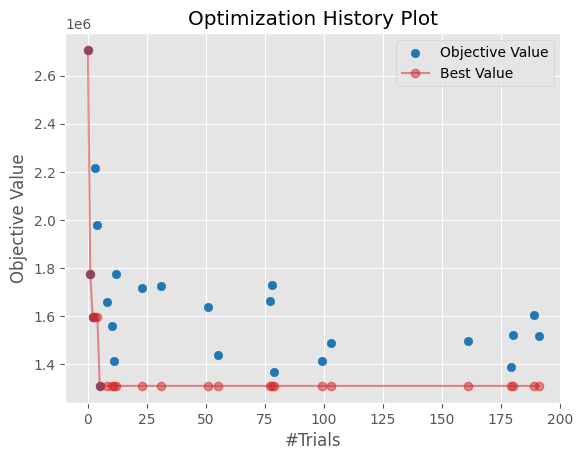

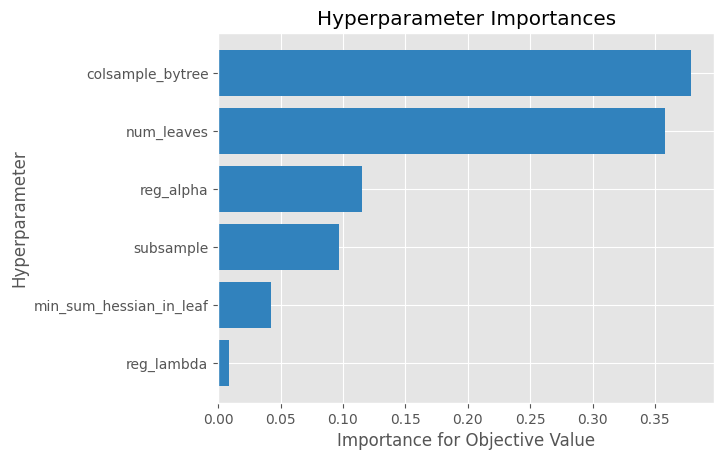

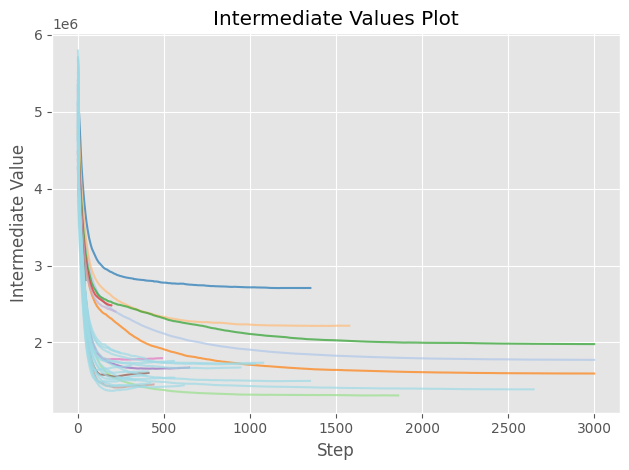

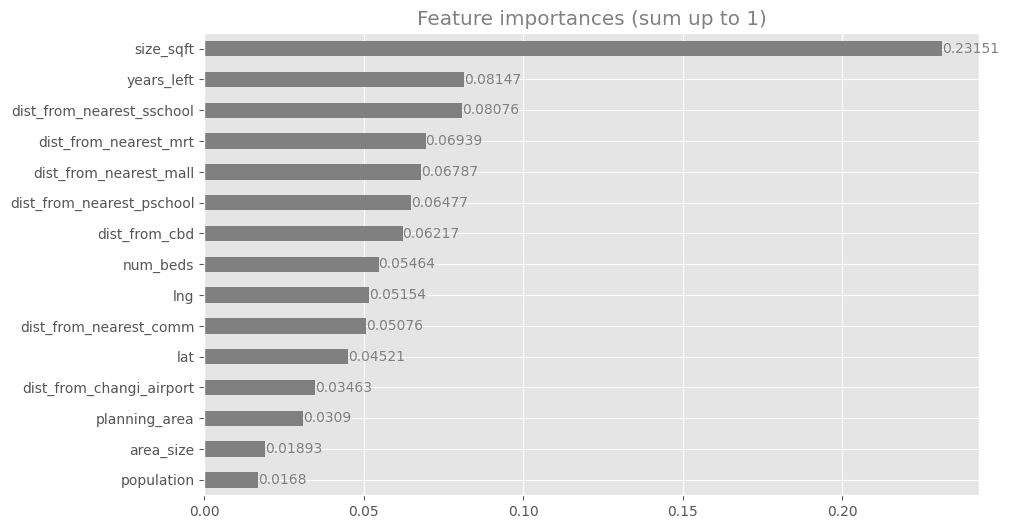


     . Optuna hyperparameters optimization finished
     .. Best trial number: 5    |     rmse:           1310927.2694392323
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  921   |     rmse:           2581546.7299288115

Time elapsed for fit execution: 3 min 35.501 sec


In [244]:
# tune the hyperparameters and fit the optimized model
tuner = LGBMTuner(metric = 'rmse',trials = 200)
tuner.fit(X_train, y_train)

In [245]:
tuner.best_params

{'learning_rate': 0.02,
 'num_leaves': 56,
 'colsample_bytree': 0.8037724259507192,
 'subsample': 0.5325257964926398,
 'verbosity': -1,
 'random_state': 42,
 'objective': 'regression',
 'metric': 'rmse',
 'num_threads': 2,
 'reg_alpha': 4.905556676028774,
 'min_sum_hessian_in_leaf': 6.245139574743075,
 'reg_lambda': 0.18861495878553936,
 'n_estimators': 921}

In [261]:
model_lgb_tune = LGBMRegressor(**best_params)

model_lgb_tune.fit(X_train,y_train)
#storing this model for Task 3- Explainable AI
pickle.dump(model_lgb_tune, open("trained_model_lgb_tune.sav", 'wb'))

predictions = model_lgb_tune.predict(X_valid)
print("MAE:", metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))

eda_func.true_vs_pred(y_valid,predictions,"<i><b>True vs predicted resale price </b></i>","True","Predicted")

eda_func.feature_importance(model_lgb_tune,X,"<i>Top 20 Feature for LightGBM with automated hyperparameter tuning<i>")


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.245139574743075, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.245139574743075
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
MAE: 393111.41337952705
MSE: 2537254572537.215
RMSE: 1592876.1949810206


**Observations** 
1. RMSE score: We achieved rmse score of 1592876.1949810206 on validation set and  score of  1720396.22544 on Kaggle Public Leaderboard on our final model.
2. Feature Importance: As anticipated, size in square feet is the most important feature. This graph demonstrates the significance of the remaining year for price prediction. Distance-based features, such as the distance from the closest primary or secondary school, are also among the top features which is a indicator of a parent's preference to purchase a home close to the school for the convenience of their children. People in Singapore frequently use the MRT for their daily commute. This is the reason it is one of the top 5 features. Given that Singapore is a financial center, some people might even want to live close to the central business district, which demonstrates why distance from the CBD has emerged as a crucial predictor.
3. True vs predicted price comparison: The plot shows that the model was able to fairly accurately represent the majority of the prices. However, a few outliers need further investigation in order to comprehend model prediction.

#### Kaggle Score with Automated Hyperparameter tuning
With Automated Hyperparameter tuning, we received rmse score of 1720396.22544 on Kaggle Public Leaderboard

# Submission


In [262]:
X_train.head(3)

,planning_area,num_beds,size_sqft,floor_level,lat,lng,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt,area_size,population,property_type_condo,property_type_hdb,property_type_landed,property_type_others,furnishing_fully,furnishing_partial,furnishing_unfurnished,furnishing_unspecified
12257,1.522314e+07,4,2422,7,1.242620,103.836821,87,21.13,4.85,2.86,4.10,3.68,5.26,3.04,3.084600,970,1,0,0,0,0,0,0,1
2394,4.880015e+06,2,700,7,1.273959,103.843635,103,18.58,1.41,0.43,1.54,0.46,1.86,0.37,0.373577,246,1,0,0,0,0,1,0,0
459,3.346090e+06,5,1711,7,1.317138,103.759701,100,25.85,10.85,0.61,0.29,0.49,1.81,0.65,1.045567,10221,1,0,0,0,0,0,0,1


In [263]:
X_train.shape

(16116, 24)

In [264]:
submit.head(3)

,property_type,num_beds,size_sqft,floor_level,furnishing,lat,lng,subzone,planning_area,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt,area_size,population,Predicted
0,condo,1,463.0,unknown,unfurnished,1.344334,103.878690,upper paya lebar,serangoon,999,12.30,7.33,0.99,0.34,0.34,1.04,0.26,1.442943,16700,1.115675e+06
1,condo,3,1033.0,high,unspecified,1.380281,103.943878,pasir ris west,pasir ris,94,5.56,14.81,0.28,1.40,1.08,1.44,1.00,1.879487,18390,1.515388e+06
2,condo,1,570.0,unknown,fully,1.294668,103.850074,bras basah,museum,84,16.90,1.20,0.21,0.56,0.34,0.16,0.25,0.276500,173,1.327315e+06


In [265]:
submit.shape

(6966, 20)

In [266]:
test_df.head(3)

,planning_area,num_beds,size_sqft,floor_level,lat,lng,years_left,dist_from_changi_airport,dist_from_cbd,dist_from_nearest_mall,dist_from_nearest_sschool,dist_from_nearest_pschool,dist_from_nearest_comm,dist_from_nearest_mrt,area_size,population,property_type_condo,property_type_hdb,property_type_landed,property_type_others,furnishing_fully,furnishing_partial,furnishing_unfurnished,furnishing_unspecified
0,3.695706e+06,1,463.0,7,1.344334,103.878690,999,12.30,7.33,0.99,0.34,0.34,1.04,0.26,1.442943,16700,1,0,0,0,0,0,1,0
1,2.732523e+06,3,1033.0,1,1.380281,103.943878,94,5.56,14.81,0.28,1.40,1.08,1.44,1.00,1.879487,18390,1,0,0,0,0,0,0,1
2,2.212662e+06,1,570.0,7,1.294668,103.850074,84,16.90,1.20,0.21,0.56,0.34,0.16,0.25,0.276500,173,1,0,0,0,1,0,0,0


In [267]:
test_df.shape

(6966, 24)

In [268]:
#for submission 
submit['Predicted'] = model_lgb_tune.predict(test_df)
#submit['Predicted'] =lgb_random_tune.predict(test_df)

In [274]:
fig = px.box(submit, x="property_type", y="Predicted",color="property_type",title="<i>Price per property type on unseen test data</i>")
fig.show()

**Observation**
Predicted price distribution of unseen test data: We observe a price trend that is somewhat reminiscent of the training data trend. While the landed properties are relatively pricey, the HDBs are among the low prices.

In [275]:
#Please uncomment this code to generate submission file for Kaggle.
# submission = submit[['Predicted']]
# submission.reset_index(inplace=True)
# submission.rename(columns={"index": "Id"}, inplace=True)
# submission.to_csv('submission.csv',index=False)

# References 

1. https://www.diva-portal.org/smash/get/diva2:1354741/FULLTEXT01.pdf
2. https://reader.elsevier.com/reader/sd/pii/S1877050920316318?token=B79536B9738DEE1EC6D463C99608C67E319CA7E2A192B3150955A7B8213DB9FB8CB157AB475DF04E43EE160BC1855A5A&originRegion=eu-west-1&originCreation=20221106054545
3. https://towardsdatascience.com/a-brief-introduction-to-xgboost-3eaee2e3e5d6#:~:text=XGBoost%20vs%20Gradient%20Boosting,can%20be%20parallelized%20across%20clusters.
4. https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
5. https://towardsdatascience.com/predicting-singapore-hdb-resale-price-eda-and-modeling-94af7d26798d
6. https://medium.com/analytics-vidhya/singapore-housing-prices-ml-prediction-analyse-singapores-property-price-part-iii-bd9438077423
7. https://royleekiat.com/2020/10/22/how-to-predict-hdb-resale-prices-using-3-different-machine-learning-models-linear-regression-neural-networks-k-nearest-neighbours/
8. https://www.kaggle.com/code/teyang/drivers-of-hdb-resale-price-and-prediction
9. https://danilzherebtsov.medium.com/effortlessly-tune-lgbm-with-optuna-49de040d0784
10. https://neptune.ai/blog/lightgbm-parameters-guide
11. https://www.kaggle.com/code/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761
12. https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-hyperparameters.html
13. https://www.analyticsvidhya.com/blog/2021/09/optimize-your-optimizations-using-optuna/
